## 1.3 Kernelised ridge regression 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from collections import Counter

In [8]:
# import CSV file
housing = pd.read_csv('Boston-filtered.csv')

#print(housing.head()) # N = 506 

In [13]:
def find_mse(y_true, y_pred):
    """ Compute MSE """
    return np.mean((y_true - y_pred) ** 2)

In [11]:
def random_split_data(data, target_variable, test_size=1/3):
    """ Split the data set into 2/3 train, 1/3 test randomly. """
    
    # total sample size
    num_samples = len(data)
    
    # shuffle indices for random split
    indices = np.arange(num_samples)
    np.random.shuffle(indices) 
    
    # calculate test sample size
    test_sample_size = int(num_samples * test_size)
    
    # split indices into train and test 
    train_indices = indices[test_sample_size:]
    test_indices = indices[:test_sample_size]
    
    # split the data into train and test sets 
    data_train = data.iloc[train_indices]
    data_test = data.iloc[test_indices]
    
    # split dataset into features and target variable for train and test
    X_train = data_train.drop(target_variable, axis=1).values  
    y_train = data_train[target_variable].values  
    
    X_test = data_test.drop(target_variable, axis=1).values  
    y_test = data_test[target_variable].values  
    
    return X_train, X_test, y_train, y_test


In [2]:
# create candidates for regularization term (from 2^(-40) to 2^(-26))
gamma_candid = [2**i for i in range(-40, -25)]

# create candidates for rbf kernel parameter (from 2^7 to 2^13, with steps of 0.5 in the exponent)
sigma_candid = [2**(7 + 0.5*i) for i in range(13)]

In [3]:
def rbf_kernel(X1, X2, sigma):
    """Define the Gaussian Kernel function"""
    square_diff = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return np.exp(-square_diff / (2 * sigma**2))

def kernel_ridge_predict(X_train, X_test, y_train, sigma, gamma):
    """ Prediction using kernel and dual formulation for train and test."""
    
    # find the kernel matrix for training and test
    K_train = rbf_kernel(X_train, X_train, sigma)  # pairwise similarities between all points in the training set
    K_test = rbf_kernel(X_test, X_train, sigma)  # similarity between each validation point and all the training points

    # solve alpha using dual formulation
    alpha = np.linalg.solve(K_train + gamma * np.eye(len(X_train)), y_train)

    # predict on the train and test set 
    y_train_pred = K_train @ alpha    
    y_test_pred = K_test @ alpha

    return y_train_pred, y_test_pred


def kfold(X, y, n_splits=5, shuffle=True, random_state=None):
    """Implementation of K-Fold Cross Validation."""
    
    n_samples = len(X)
    indices = np.arange(n_samples)

    # shuffle the data if required
    if shuffle:
        if random_state is not None:
            np.random.seed(random_state)
        np.random.shuffle(indices)

    # calculate the size of each fold
    fold_size = n_samples // n_splits

    for i in range(n_splits):
        # Determine the test fold indices
        test_start = i * fold_size
        test_end = (i + 1) * fold_size if i < n_splits - 1 else n_samples  

        # split indices into train and test 
        test_index = indices[test_start:test_end]
        train_index = np.setdiff1d(indices, test_index)

        # yield the train and test indices
        yield train_index, test_index


In [17]:
def run_all_methods(data, target_variable, n_runs=20, add_plot = False):
    """ run all 3 regression methods, report and plot MSE """
    # Get MSE from each method
    avg_mse_train_naive, avg_mse_test_naive, std_mse_train_naive, std_mse_test_naive = naive_regression(data, target_variable, n_runs)
    avg_mse_train_single, avg_mse_test_single, std_mse_train_single, std_mse_test_single = single_attribute_regression(data, target_variable, n_runs)
    avg_mse_train_all, avg_mse_test_all, std_mse_train_all, std_mse_test_all = all_attributes_regression(data, target_variable, n_runs)

    # Print average MSE for each method
    print(f"{n_runs} Runs are Implemented for Each Regression Method")
    
    print("--------------------------------------------------")
    print(f"Naive Regression - Average Train MSE: {avg_mse_train_naive}, Test MSE: {avg_mse_test_naive}" )
    print(f"Naive Regression - Standard Deviation Train MSE: {std_mse_train_naive}, Test MSE: {std_mse_test_naive}" )
    
    print("--------------------------------------------------")
    print(f"Single Attribute Regression - Average Train MSE: {avg_mse_train_single}, Test MSE: {avg_mse_test_single}")
    print(f"Single Attribute Regression - Standard Deviation Train MSE: {std_mse_train_single}, Test MSE: {std_mse_test_single}" )
    
    print("--------------------------------------------------")
    print(f"All Attributes Regression - Average Train MSE: {avg_mse_train_all}, Test MSE: {avg_mse_test_all}")
    print(f"All Attribute Regression - Standard Deviation Train MSE: {std_mse_train_all}, Test MSE: {std_mse_test_all}" )
    
    if add_plot:
        # get 12 attribute names from the data
        attribute_names = data.columns[:12].tolist()  
        
        # Plotting
        fig, ax = plt.subplots(figsize=(12, 6))

        # Bar positions
        x_naive = np.array([0])
        x_single = np.arange(1, len(avg_mse_train_single) + 1)  
        x_all = np.array([len(avg_mse_train_single) + 1]) 
        
        # Bar widths
        width = 0.35
        
        # plot for Naive regression
        ax.bar(x_naive - width / 2, [avg_mse_train_naive], width, color='lightblue')
        ax.bar(x_naive + width / 2, [avg_mse_test_naive], width, color='orange')
        
        # plot for Single attribute regression
        ax.bar(x_single - width / 2, avg_mse_train_single, width, label='Train', color='lightblue')
        ax.bar(x_single + width / 2, avg_mse_test_single, width, label='Test', color='orange')
        
        # plot for All attributes regression
        ax.bar(x_all - width / 2, [avg_mse_train_all], width, color='lightblue')
        ax.bar(x_all + width / 2, [avg_mse_test_all], width, color='orange')
        
        # add labels and title
        ax.set_xlabel('Regression Methods / Attributes')
        ax.set_ylabel(f'Average MSE acrros {n_runs} Runs')
        ax.set_title('Comparison of MSE for Different Regression Methods')
        ax.set_xticks(np.concatenate([x_naive, x_single, x_all]))
        ax.set_xticklabels(['Naive'] + attribute_names + ['All Attributes'])
        
        ax.legend()
        plt.tight_layout()
        plt.show()



In [19]:
# 1. Naive Regression (Predicting with the mean y-value on the training set.)
def naive_regression( data, target_variable, n_runs=20):
    mse_train_list = []
    mse_test_list = []

    for _ in range(n_runs):
        # get random splitted dataset
        X_train, X_test, y_train, y_test = random_split_data(data, target_variable)

        # create a vector of ones for both training and testing (constant function)
        X_train_ones = np.ones((X_train.shape[0], 1))  # Adding bias term (a column of ones)
        X_test_ones = np.ones((X_test.shape[0], 1))

        # estimate weights: mean of y_train
        w = linear_regression(X_train_ones, y_train, method = 'primal')
        
        # predict y using the constant function w
        y_train_pred = X_train_ones * w
        y_test_pred = X_test_ones * w

        # calculate MSE for train and test
        mse_train = find_mse(y_train, y_train_pred)
        mse_test = find_mse(y_test, y_test_pred)

        mse_train_list.append(mse_train)
        mse_test_list.append(mse_test)

    # Return the average MSE over the n_runs
    return np.mean(mse_train_list), np.mean(mse_test_list), np.std(mse_train_list), np.std(mse_test_list)


# 2. Linear Regression with Single Attributes (Predicting with a single attribute and a bias term.)
def single_attribute_regression(data, target_variable, n_runs=20):
    mse_train_list = np.zeros((n_runs, data.shape[1] - 1))  # n_runs iterations, 12 attributes
    mse_test_list = np.zeros((n_runs, data.shape[1] - 1))

    for run in range(n_runs):
        # get random splitted dataset
        X_train, X_test, y_train, y_test = random_split_data(data, target_variable)

        # perform linear regression with each attribute and a bias term
        for attr in range(X_train.shape[1]):
            # filter the current attribute 
            X_train_attr = X_train[:, attr].reshape(-1, 1)
            X_test_attr = X_test[:, attr].reshape(-1, 1)

            # add bias term (i.e. a column of ones)
            X_train_attr = np.hstack([X_train_attr, np.ones((X_train_attr.shape[0], 1))])
            X_test_attr = np.hstack([X_test_attr, np.ones((X_test_attr.shape[0], 1))])

            # estimate weights
            w = linear_regression(X_train_attr, y_train, method = 'primal')
            
            # predict y using esimated weights
            y_train_pred = X_train_attr @ w
            y_test_pred = X_test_attr @ w

            # calculate MSE for train and test
            mse_train = find_mse(y_train, y_train_pred)
            mse_test = find_mse(y_test, y_test_pred)

            # save the MSE for the current attribute (across all runs)
            mse_train_list[run, attr] = mse_train
            mse_test_list[run, attr] = mse_test

    # Compute average MSE for each attribute (across 20 runs)
    avg_mse_train = np.mean(mse_train_list, axis=0)
    avg_mse_test = np.mean(mse_test_list, axis=0)
    std_mse_train = np.std(mse_train_list, axis=0)
    std_mse_test = np.std(mse_test_list, axis=0)

    return avg_mse_train, avg_mse_test, std_mse_train, std_mse_test


# 3. Linear Regression using All Attributes and a bias term
def all_attributes_regression(data, target_variable, n_runs=20):
    mse_train_list = []
    mse_test_list = []

    for _ in range(n_runs):
        # get random splitted dataset
        X_train, X_test, y_train, y_test = random_split_data(data, target_variable)

        # add bias term (i.e. a column of ones)
        X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
        X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

        # estimate weights
        w = linear_regression(X_train, y_train, method = 'primal')

        # predict y using esimated weights
        y_train_pred = X_train @ w
        y_test_pred = X_test @ w

        # calculate MSE for train and test
        mse_train = find_mse(y_train, y_train_pred)
        mse_test = find_mse(y_test, y_test_pred)
        
        mse_train_list.append(mse_train)
        mse_test_list.append(mse_test)

    return np.mean(mse_train_list), np.mean(mse_test_list), np.std(mse_train_list), np.std(mse_test_list)


In [4]:
# Cross-validation to select best gamma and sigma
def cv_kernel_ridge(X_train, y_train, gamma_values, sigma_values):
    
    best_mse = float('inf')
    best_gamma, best_sigma = None, None
    mse_matrix = np.zeros((len(gamma_values), len(sigma_values)))  

    for i, gamma in enumerate(gamma_values):
        for j, sigma in enumerate(sigma_values):
            mse_fold = []
            for train_index, val_index in kfold(X_train, y_train):
                X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
                y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
                
                # Prediction using kernel and dual formulation for validation
                _, y_val_pred = kernel_ridge_predict(X_train_fold, X_val_fold, y_train_fold, sigma, gamma)
                mse_fold.append(find_mse(y_val_fold, y_val_pred))

            # calculate the average MSE for all folds using gamma_i and sigma_j
            avg_mse = np.mean(mse_fold)
            mse_matrix[i, j] = avg_mse  
            
            # update parameters if MSE smaller
            if avg_mse < best_mse:
                best_mse = avg_mse
                best_gamma, best_sigma = gamma, sigma

    return best_gamma, best_sigma, mse_matrix


In [5]:
def retrained_ridge_mse(X_train, y_train, X_test, y_test, best_gamma, best_sigma):
    """Compute the MSE on train and test set using the best gamma and sigma"""
    
    # Prediction using kernel and dual formulation for train and test
    y_train_pred, y_test_pred = kernel_ridge_predict(X_train, X_test, y_train, best_sigma, best_gamma)

    # Compute the MSE on the train and test set
    train_mse = find_mse(y_train, y_train_pred)
    test_mse = find_mse(y_test, y_test_pred)

    return train_mse, test_mse


def plot_cv_error(gamma_values, sigma_values, mse_matrix):
    """Plot the cross-validation error (MSE) as a function of gamma and sigma"""
    # Plotting the MSE matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(mse_matrix, aspect='auto', origin='lower', cmap='magma', interpolation='nearest')
    plt.colorbar(label='MSE')
    
    # Formatting gamma and sigma values as 2^x
    gamma_labels = [f'$2^{{{int(np.log2(g))}}}$' for g in gamma_values]
    sigma_labels = [f'$2^{{{s:.1f}}}$' for s in np.log2(sigma_values)]

    plt.xticks(np.arange(len(sigma_values)), sigma_labels)
    plt.yticks(np.arange(len(gamma_values)), gamma_labels)
 
    plt.xlabel('Sigma values')
    plt.ylabel('Gamma values')
    plt.title('Cross-validation error (MSE) for Different gamma and sigma values')
    plt.show()

In [21]:
def linear_regression(X, y, method='pseudo'):
    """Estimate linear regression coefficients using different formulation"""
    
    if method == 'primal': 
        #return np.linalg.inv(X.T @ X) @ (X.T @ y) 
        return np.linalg.solve(X.T @ X, X.T @ y)
    
    elif method == 'pseudo':  
        return np.linalg.pinv(X.T @ X) @ (X.T @ y)

In [9]:
def run_kernel_ridge(data, target_column, gamma_candid, sigma_candid, n_runs=1, plot=False):
    """ Perform multiple runs of Kernel Ridge Regression."""
    
    # result storage for each iteration
    all_results = []

    for run in range(n_runs):
        print(f"Run {run + 1}/{n_runs}:")

        # radnom split the data into 2/3 training and 1/3 test 
        X_train, X_test, y_train, y_test = random_split_data(data, target_column)

        # perform 5 fold cross-validation to find the best parameters: gamma and sigma
        best_gamma, best_sigma, mse_matrix = cv_kernel_ridge(X_train, y_train, gamma_candid, sigma_candid)
        
        # converts the best parameters into the format 2^x
        gamma_exponent = np.log2(best_gamma)
        sigma_exponent = np.log2(best_sigma)
        
        # reformat the parameters into the 2^x form
        gamma_reformat = f"$2^{{{gamma_exponent:.0f}}}$"  # integer for gamma
        sigma_reformat = f"$2^{{{sigma_exponent:.1f}}}$"  # float for sigma 
        
        print(f"Best gamma: {gamma_reformat}, Best sigma: {sigma_reformat}")

        # compute MSE for both the training and test using the best parameters found above
        train_mse, test_mse = retrained_ridge_mse(X_train, y_train, X_test, y_test, best_gamma, best_sigma)
        print(f"Training MSE: {train_mse}")
        print(f"Test MSE: {test_mse}")

        # Store the results of this run
        all_results.append((best_gamma, best_sigma, train_mse, test_mse))

        # Plot the cross-validation error matrix if true
        if plot:
            plot_cv_error(gamma_candid, sigma_candid, mse_matrix)
    
    if n_runs > 1:
        # calculate the mean and standard deviation for training and test MSE for all runs
        all_train_mse = [result[2] for result in all_results]  
        all_test_mse = [result[3] for result in all_results]   

        mean_train_mse = np.mean(all_train_mse)
        std_train_mse = np.std(all_train_mse)
        mean_test_mse = np.mean(all_test_mse)
        std_test_mse = np.std(all_test_mse)

        # Report the mean and standard deviation for training and test MSE
        print("--------------------------------------------------")
        print(f"Mean Training MSE: {mean_train_mse}, Standard Deviation: {std_train_mse}")
        print(f"Mean Test MSE: {mean_test_mse}, Standard Deviation: {std_test_mse}")

        return mean_train_mse, std_train_mse, mean_test_mse, std_test_mse

Run 1/1:
Best gamma: $2^{-35}$, Best sigma: $2^{12.5}$
Training MSE: 7.738995238665572
Test MSE: 14.633268302592915


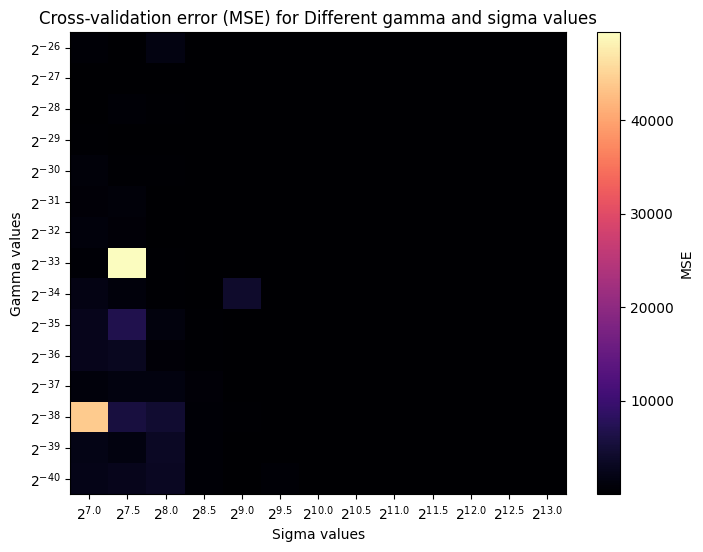

In [14]:
# perform 1 runs of kernel ridge regression with ploting
results = run_kernel_ridge(housing, 'MEDV', gamma_candid, sigma_candid, n_runs=1, plot=True)

In [15]:
# perform 20 runs of kernel ridge regression 
results = run_kernel_ridge(housing, 'MEDV', gamma_candid, sigma_candid, n_runs=20)

Run 1/20:
Best gamma: $2^{-38}$, Best sigma: $2^{12.5}$
Training MSE: 8.512202446765471
Test MSE: 10.571697134031204
Run 2/20:
Best gamma: $2^{-26}$, Best sigma: $2^{11.0}$
Training MSE: 9.18870610521631
Test MSE: 13.003571407975512
Run 3/20:
Best gamma: $2^{-33}$, Best sigma: $2^{11.5}$
Training MSE: 7.89941069658581
Test MSE: 11.277275688972193
Run 4/20:
Best gamma: $2^{-30}$, Best sigma: $2^{10.5}$
Training MSE: 6.877450825647261
Test MSE: 12.94296631632644
Run 5/20:
Best gamma: $2^{-28}$, Best sigma: $2^{10.5}$
Training MSE: 6.779664845181238
Test MSE: 13.960481714484981
Run 6/20:
Best gamma: $2^{-26}$, Best sigma: $2^{10.5}$
Training MSE: 7.887425754754013
Test MSE: 13.105094435152079
Run 7/20:
Best gamma: $2^{-36}$, Best sigma: $2^{11.0}$
Training MSE: 4.252939349871415
Test MSE: 16.635787437302724
Run 8/20:
Best gamma: $2^{-40}$, Best sigma: $2^{12.5}$
Training MSE: 8.448000705425555
Test MSE: 10.472314957209997
Run 9/20:
Best gamma: $2^{-28}$, Best sigma: $2^{11.5}$
Training MS

In [22]:
# Run all 3 methods with 20 different random splits and plot
run_all_methods(housing, 'MEDV' , n_runs=20)

20 Runs are Implemented for Each Regression Method
--------------------------------------------------
Naive Regression - Average Train MSE: 86.21557325986485, Test MSE: 80.9216304947139
Naive Regression - Standard Deviation Train MSE: 3.9996144953530597, Test MSE: 8.01639072402734
--------------------------------------------------
Single Attribute Regression - Average Train MSE: [70.82605686 72.87380118 63.75769526 81.06645535 68.25647162 42.77093659
 71.68564515 78.46743237 71.56075349 65.39573756 62.36413516 37.8044832 ], Test MSE: [75.2815698  75.18113711 67.10864513 84.24272645 70.95939665 46.00869981
 74.51276112 81.17244478 73.81172698 67.46328076 63.75913499 40.22594631]
Single Attribute Regression - Standard Deviation Train MSE: [4.48858267 5.07652071 5.27092894 4.36379089 5.33284995 3.42775569
 5.29141893 5.25417474 4.98576315 5.0001933  2.81149577 2.74471027], Test MSE: [10.25230815 10.3396988  10.6878114   9.01728744 10.80917758  6.74391959
 10.65045818 10.61215241 10.154869